In [1]:
import os.path as op

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import AFQ.registration as reg

In [4]:
from glob import glob
import nibabel as nib

In [5]:
path = '/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/'

In [6]:
real_a_files = glob(op.join(path, 'IXI029*real_A*'))
real_b_files = glob(op.join(path, 'IXI029*real_B*'))
fake_b_files = glob(op.join(path, 'IXI029*fake_B*'))

In [7]:
real_a_files.sort()
real_b_files.sort()
fake_b_files.sort()

In [8]:
real_a = np.zeros((len(real_a_files), 128, 128, 3))
real_b = np.zeros((len(real_a_files), 128, 128, 3))
fake_b = np.zeros((len(real_a_files), 128, 128, 3))
for ii in range(len(real_a_files)):
    real_a[ii]= np.load(real_a_files[ii]) 
    real_b[ii]= np.load(real_b_files[ii]) 
    fake_b[ii]= np.load(fake_b_files[ii])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


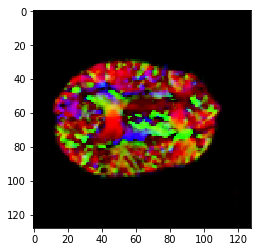

In [9]:
plt.imshow(fake_b[27])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


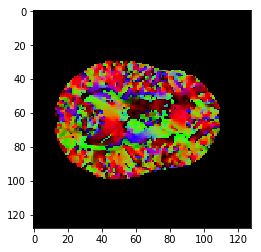

In [10]:
plt.imshow(real_b[27])

In [11]:
meanV1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmean_V1.nii.gz')

In [12]:
meanV1 = meanV1_img.get_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


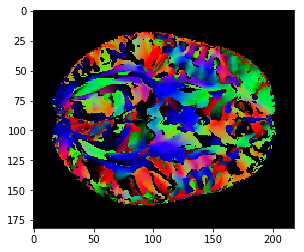

In [13]:
plt.imshow(meanV1[:, :, 80])

In [14]:
meant1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmean_t1.nii.gz')

In [15]:
meant1 = meant1_img.get_data()

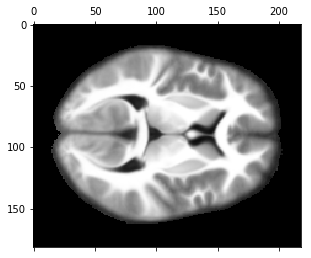

In [16]:
plt.matshow(meant1[:, :, 80], cmap='gray')

In [17]:
meanV1.shape

(182, 218, 182, 3)

In [18]:
meant1.shape

(182, 218, 182)

In [19]:
ants_brain_img = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-T1_ants_brainextractionBrainExtractionBrain.nii.gz')

In [20]:
ants_brain = ants_brain_img.get_data()

In [21]:
transformed, affine = reg.affine_registration(meant1, ants_brain, meant1_img.affine, ants_brain_img.affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [22]:
warped_meant1, mapping = reg.syn_registration(meant1, ants_brain, moving_affine=meant1_img.affine, static_affine=ants_brain_img.affine, prealign=affine)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


In [23]:
nib.save(nib.Nifti1Image(warped_meant1, ants_brain_img.affine), '/Users/arokem/data/mri2mri/meant1_warped_to_ants_brain.nii.gz')

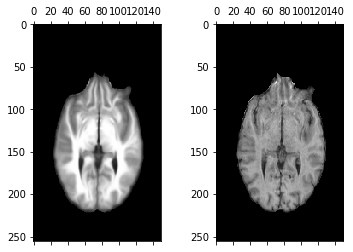

In [24]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(warped_meant1[:, 150, :], cmap='gray')
ax[1].matshow(ants_brain[:, 150, :], cmap='gray')

In [25]:
mapped = np.concatenate([mapping.transform(meanV1[..., 0])[..., np.newaxis], 
                         mapping.transform(meanV1[..., 1])[..., np.newaxis], 
                         mapping.transform(meanV1[..., 2])[..., np.newaxis]], -1) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


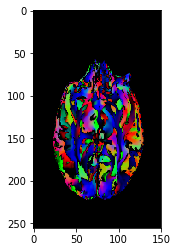

In [26]:
plt.imshow(mapped[:, 150, :])

In [27]:
DWI_img = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-DTI-00.nii.gz')

In [28]:
DWI_affine = DWI_img.affine

In [29]:
resamp = np.concatenate([reg.resample(mapped[..., 0], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                         reg.resample(mapped[..., 1], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                         reg.resample(mapped[..., 2], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis]], -1)[:,:,1:-1]
                         

In [30]:
resamp = np.moveaxis(resamp, 2, 0)

In [31]:
resamp.shape

(54, 128, 128, 3)

In [32]:
fake_b.shape

(54, 128, 128, 3)

In [33]:
real_b.shape

(54, 128, 128, 3)

In [34]:
nib.save(nib.Nifti1Image(real_b, DWI_affine), '/Users/arokem/data/mri2mri/real_b.nii.gz')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


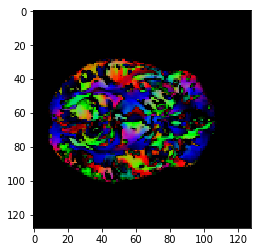

In [35]:
plt.imshow(resamp[24])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


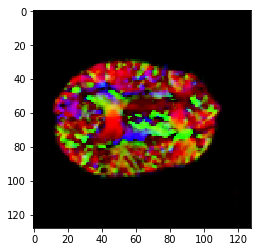

In [36]:
plt.imshow(fake_b[27])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


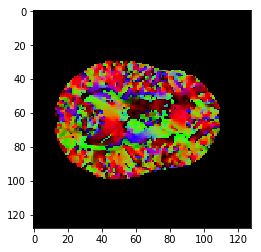

In [37]:
plt.imshow(real_b[27])

In [38]:
mask = (np.abs(real_b).sum(-1)) > 0 

In [39]:
angle_fake = np.rad2deg(np.arccos(np.clip((real_b[mask] * fake_b[mask]).sum(axis=-1), -1, 1)))
    
angle_fake = np.min(np.array([angle_fake, 180-angle_fake]), 0)

In [40]:
angle_template = np.rad2deg(np.arccos(np.clip((real_b[mask] * resamp[mask]).sum(axis=-1), -1, 1)))
angle_template = np.min(np.array([angle_template, 180-angle_template]), 0)

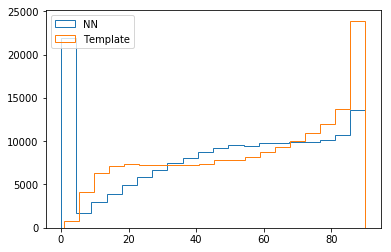

In [41]:
fig, ax = plt.subplots(1)
ax.hist(angle_fake, histtype='step', bins=20, label="NN")
ax.hist(angle_template, histtype='step', bins=20, label="Template")
plt.legend(loc="upper left")

In [42]:
errormap_template = np.zeros(real_b.shape[:3]) * np.nan
errormap_fake = np.zeros(real_b.shape[:3]) * np.nan

In [43]:
errormap_template[mask] = angle_template

In [44]:
errormap_fake[mask] = angle_fake

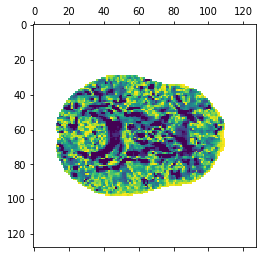

In [45]:
plt.matshow(errormap_fake[27], vmin=0, vmax=90)

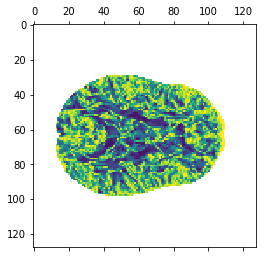

In [46]:
plt.matshow(errormap_template[27], vmin=0, vmax=90)